In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
from torch.utils.data import DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
from datasets import load_dataset
ag_news = load_dataset("ag_news")
train_data_full = ag_news['train']
test_data = ag_news['test']
train_data_full = train_data_full.to_pandas()
test_data = test_data.to_pandas()
train_data_full.head()

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [6]:
# Print sizes
print(f"Train size: {len(train_data_full)}, Test size: {len(test_data)}")

Train size: 120000, Test size: 7600


In [7]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_data_full, test_size=0.2, random_state=42)
# Print sizes
print(f"Train size: {len(train_data)}, Test size: {len(val_data)}")

Train size: 96000, Test size: 24000


In [8]:
import re
from collections import Counter
from itertools import chain

# Tokenization function
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Lowercase and remove punctuation
    return text.split()

# Build a vocabulary from the training data
def build_vocab(dataset, min_freq=1):
    counter = Counter(chain.from_iterable(tokenize(text) for text in dataset))
    vocab = {word: idx + 2 for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    vocab["<unk>"] = 0
    vocab["<pad>"] = 1
    return vocab

# Apply the vocabulary to encode text
def encode_text(text, vocab, max_len=128):
    tokens = tokenize(text)
    encoded = [vocab.get(token, vocab['<unk>']) for token in tokens[:max_len]]
    encoded.extend([vocab['<pad>']] * (max_len - len(encoded)))
    return encoded

# Build vocab
vocab = build_vocab(train_data['text'])
print(f"Vocabulary size: {len(vocab)}")

# Encode datasets
train_data['encoded'] = train_data['text'].apply(lambda x: encode_text(x, vocab))
val_data['encoded'] = val_data['text'].apply(lambda x: encode_text(x, vocab))
test_data['encoded'] = test_data['text'].apply(lambda x: encode_text(x, vocab))

Vocabulary size: 91592


In [9]:
from torch.utils.data import Dataset

class AGNewsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.data.iloc[idx]['encoded'], dtype=torch.long),
            'label': torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)  # Labels should start from 0
        }

# Create datasets
train_dataset = AGNewsDataset(train_data)
val_dataset = AGNewsDataset(val_data)
test_dataset = AGNewsDataset(test_data)

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, hidden_dim, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x.permute(1, 0, 2))
        return self.fc(self.dropout(x[0]))

In [11]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(vocab)
embed_dim = 128
num_heads = 4
hidden_dim = 512
num_layers = 4
num_classes = 4
dropout = 0.1

In [12]:
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_tr = 0
    total_tr = 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()

        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Get predictions
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        total_tr += labels.size(0)
        correct_tr += (preds == labels.cpu().numpy()).sum()

    train_acc = 100 * correct_tr / total_tr

    return total_loss / len(loader), train_acc

In [13]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)

    return total_loss / len(loader), acc, precision, recall, cm

In [14]:
# Hyperparameter grid
hyperparams = {
    "learning_rates": [1e-4, 1e-3],
    "batch_sizes": [32, 64]
}

In [15]:
def train_and_evaluate(model, criterion, train_loader, val_loader, learning_rate, device, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracies = []
    val_accuracies = []

    train_losses = []
    val_losses = []

    best_val_acc = 0  # To track the best validation accuracy
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_precision, val_recall, _ = evaluate_model(model, val_loader, criterion, device)

        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        val_accuracies.append(100 * val_acc)
        val_losses.append(val_loss)

        # Print metrics
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {100 * val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}\n")

    return train_accuracies, train_losses, val_accuracies, val_losses

In [16]:
from itertools import product
import pandas as pd

results = []
epochs = 5
criterion = nn.CrossEntropyLoss().to(device)
# Iterate over all hyperparameter combinations
for lr, bs in product(hyperparams["learning_rates"], hyperparams["batch_sizes"]):
    print(f"For configuration: Learning Rate = {lr}, Batch Size = {bs}\n")

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs)

    # Reinitialize the model for each configuration
    model = TransformerModel(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, dropout).to(device)

    # Train and evaluate
    train_accuracies, train_losses, val_accuracies, val_losses = train_and_evaluate(model, criterion, train_loader, val_loader, lr, device, epochs)

    results.append({
        "model": model,
        "learning_rate": lr,
        "batch_size": bs,
        "train_accuracies": train_accuracies,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "val_losses": val_losses}
    )

# Convert to DataFrame
plot_df = pd.DataFrame(results)

For configuration: Learning Rate = 0.0001, Batch Size = 32

Epoch 1/5
Train Loss: 0.7111, Accuracy: 71.0500
Validation Loss: 0.4682, Accuracy: 83.1667, Precision: 0.8377, Recall: 0.8317

Epoch 2/5
Train Loss: 0.3987, Accuracy: 86.0312
Validation Loss: 0.3833, Accuracy: 86.7542, Precision: 0.8681, Recall: 0.8675

Epoch 3/5
Train Loss: 0.3283, Accuracy: 88.5812
Validation Loss: 0.3402, Accuracy: 88.2958, Precision: 0.8832, Recall: 0.8830

Epoch 4/5
Train Loss: 0.2834, Accuracy: 90.1542
Validation Loss: 0.3323, Accuracy: 88.8833, Precision: 0.8889, Recall: 0.8888

Epoch 5/5
Train Loss: 0.2488, Accuracy: 91.4844
Validation Loss: 0.3145, Accuracy: 89.4708, Precision: 0.8945, Recall: 0.8947

For configuration: Learning Rate = 0.0001, Batch Size = 64

Epoch 1/5
Train Loss: 0.7724, Accuracy: 67.8760
Validation Loss: 0.4886, Accuracy: 82.2667, Precision: 0.8248, Recall: 0.8227

Epoch 2/5
Train Loss: 0.4284, Accuracy: 84.8021
Validation Loss: 0.3994, Accuracy: 85.8000, Precision: 0.8603, Recall:

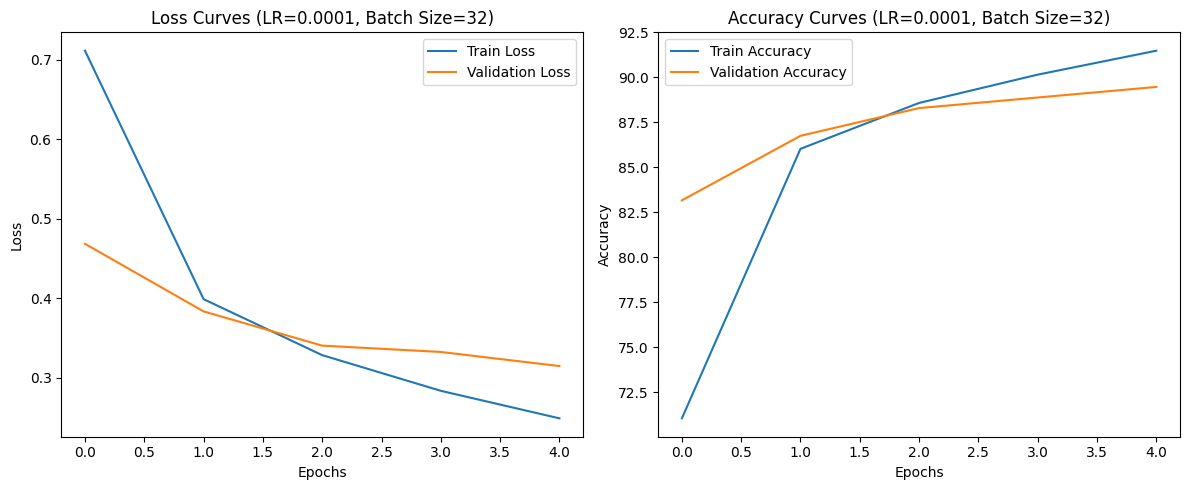

In [17]:
import matplotlib.pyplot as plt

config = plot_df.iloc[0]
lr = config['learning_rate']
bs = config['batch_size']

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(config["train_losses"], label="Train Loss")
plt.plot(config["val_losses"], label="Validation Loss")
plt.title(f"Loss Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(config["train_accuracies"], label="Train Accuracy")
plt.plot(config["val_accuracies"], label="Validation Accuracy")
plt.title(f"Accuracy Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

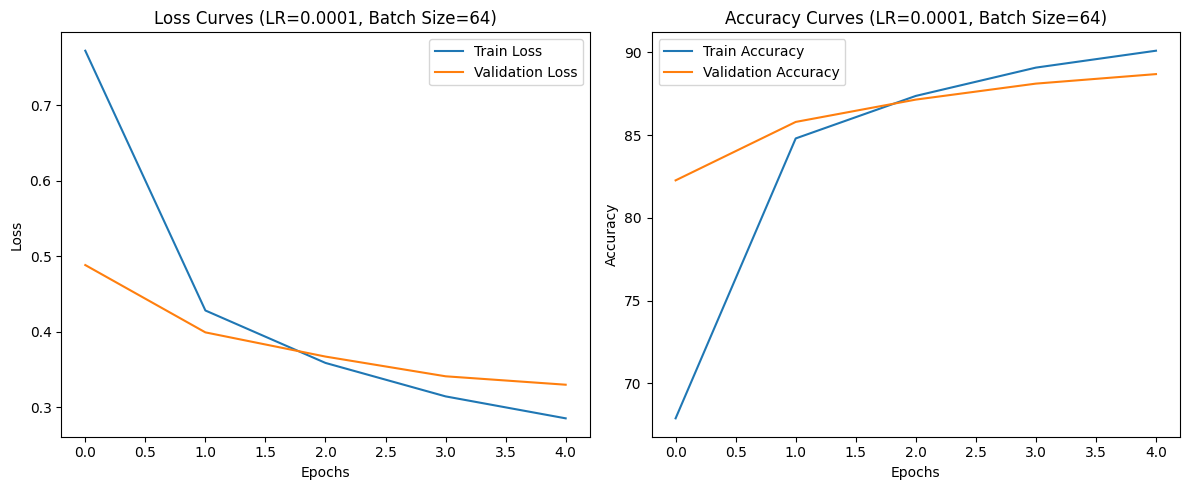

In [18]:
config = plot_df.iloc[1]
lr = config['learning_rate']
bs = config['batch_size']

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(config["train_losses"], label="Train Loss")
plt.plot(config["val_losses"], label="Validation Loss")
plt.title(f"Loss Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(config["train_accuracies"], label="Train Accuracy")
plt.plot(config["val_accuracies"], label="Validation Accuracy")
plt.title(f"Accuracy Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

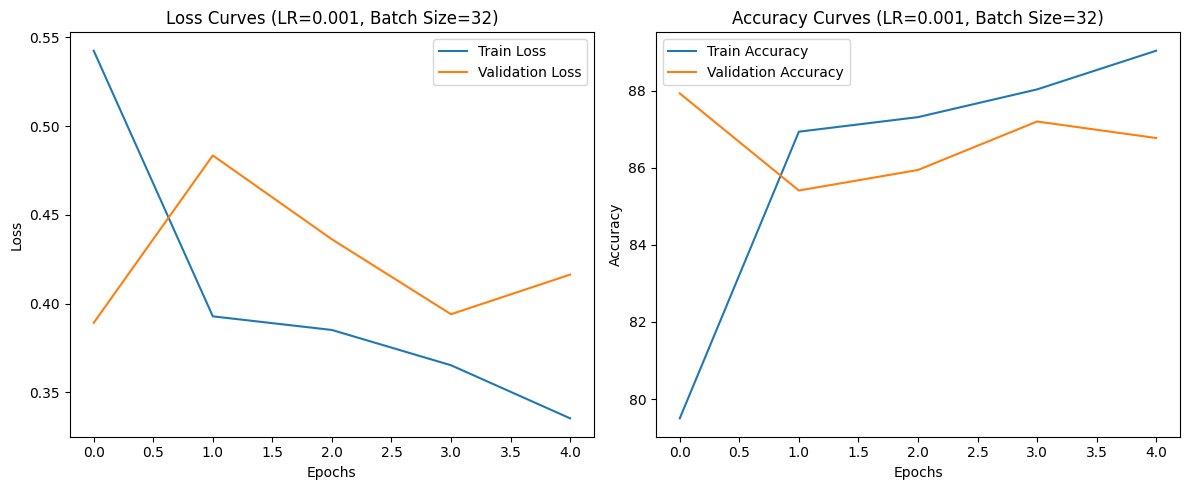

In [19]:
config = plot_df.iloc[2]
lr = config['learning_rate']
bs = config['batch_size']

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(config["train_losses"], label="Train Loss")
plt.plot(config["val_losses"], label="Validation Loss")
plt.title(f"Loss Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(config["train_accuracies"], label="Train Accuracy")
plt.plot(config["val_accuracies"], label="Validation Accuracy")
plt.title(f"Accuracy Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

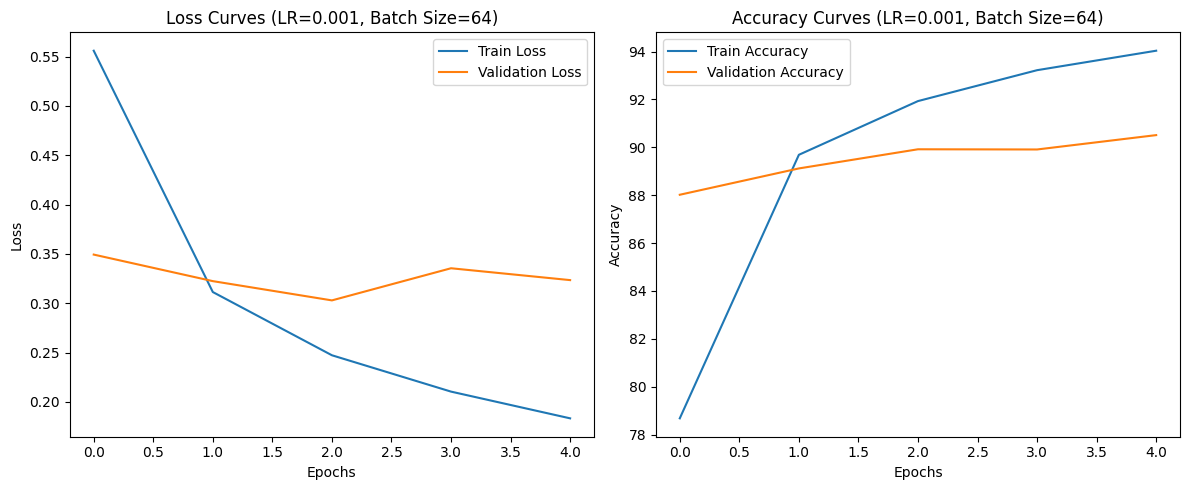

In [20]:
config = plot_df.iloc[3]
lr = config['learning_rate']
bs = config['batch_size']

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(config["train_losses"], label="Train Loss")
plt.plot(config["val_losses"], label="Validation Loss")
plt.title(f"Loss Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(config["train_accuracies"], label="Train Accuracy")
plt.plot(config["val_accuracies"], label="Validation Accuracy")
plt.title(f"Accuracy Curves (LR={lr}, Batch Size={bs})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Find the best configuration based on validation accuracy
best_config = max(results, key=lambda x: x["val_accuracies"][-1])
print(f"Best Configuration: LR={best_config['learning_rate']}, Batch Size={best_config['batch_size']}")

Best Configuration: LR=0.001, Batch Size=64


In [22]:
# Evaluate on the test set
test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
test_loss, test_acc, test_precision, test_recall, test_cm = evaluate_model(best_config['model'], test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Loss: 0.3415
Test Accuracy: 0.8997
Test Precision: 0.8997
Test Recall: 0.8997


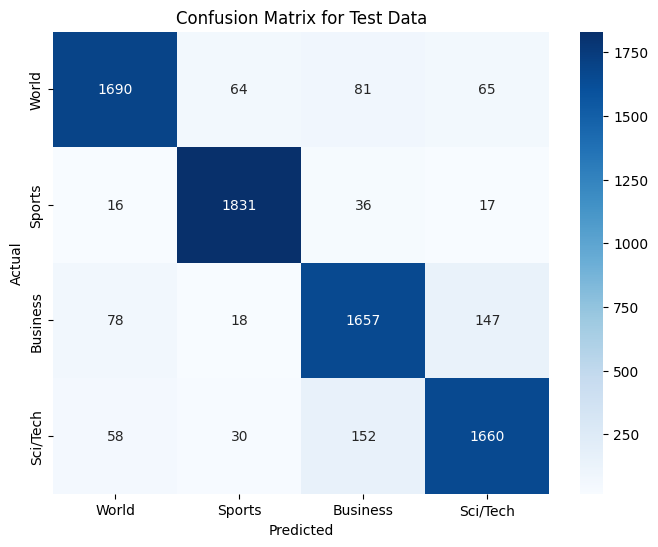

In [23]:
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'],
            yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Data')
plt.show()